In [0]:
#No Fuss Distance Metric Learning using Proxies

In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8356071.54it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 133790.36it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2221459.20it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50917.27it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

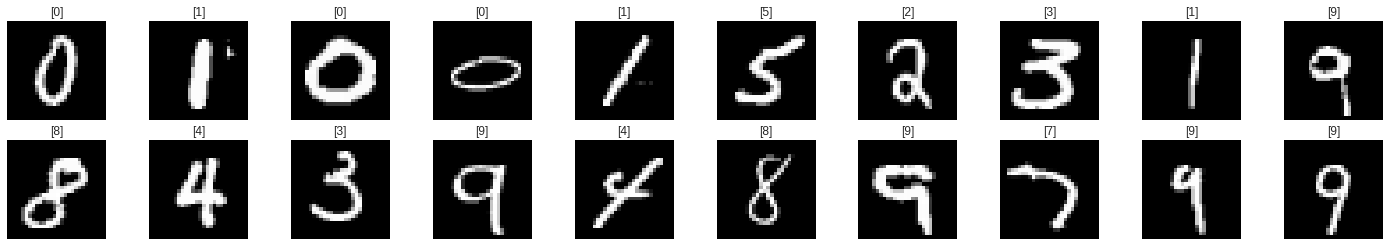

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  

In [0]:
img_size = 28*28
def d(x, y):
  return torch.sqrt(torch.sum(torch.pow(x.view(1,img_size)-y,2), dim=1))

In [0]:

def train(lr, epochs, digits, nproxy, mode='supervised'):
  y = torch.autograd.Variable(torch.randn(nproxy, img_size), requires_grad=True)
  x_loader = validation_loader #TEMP: Use validation data for training
  for e in range(epochs):
    for inputs, labels in x_loader:
      L = torch.tensor(0.0, requires_grad=True)
      for x, k in zip(inputs, labels):
        if k.item() not in digits:
          continue
        
        if mode == 'supervised':
          py, idx_py = d(x, y[k]), k
        elif mode == 'unsupervised':
          py, idx_py = torch.min(d(x,y), dim=0)
        L = L + py + torch.logsumexp( - d(x, torch.cat([y[0:idx_py], y[idx_py+1:]])), dim=0)
        
      L.backward()
      #y = y - lr * y.grad.data
      #yn = torch.norm(y, dim=1).detach()
      #y = y.div(yn.view(nproxy,-1))
      #y = torch.autograd.Variable(y, requires_grad=True)
      y = torch.autograd.Variable(y - lr * y.grad.data, requires_grad=True)
      
    print('epoch:', e, " L:", L.item())
  return y
    
def plot_proxies(y, nproxy):
  fig = plt.figure(figsize=(25,4))
  for idx in np.arange(nproxy):
    ax = fig.add_subplot(1, nproxy, idx+1, xticks=[], yticks=[])

    image = y[idx].detach().numpy().reshape([28,28])
    image = image * 0.5 + 0.5
    image = image.clip(0,1)
    plt.imshow(image)

epoch: 0  L: -285.9969177246094
epoch: 1  L: -340.14593505859375
epoch: 2  L: -368.8292236328125
epoch: 3  L: -391.1395263671875
epoch: 4  L: -410.7537536621094
epoch: 5  L: -428.99200439453125
epoch: 6  L: -446.4399108886719
epoch: 7  L: -463.39410400390625
epoch: 8  L: -480.0203857421875
epoch: 9  L: -496.4178771972656
epoch: 10  L: -512.64990234375
epoch: 11  L: -528.7582397460938
epoch: 12  L: -544.7716064453125
epoch: 13  L: -560.710693359375
epoch: 14  L: -576.590576171875
epoch: 15  L: -592.4224853515625
epoch: 16  L: -608.2147216796875
epoch: 17  L: -623.9742431640625
epoch: 18  L: -639.7064208984375
epoch: 19  L: -655.4149780273438


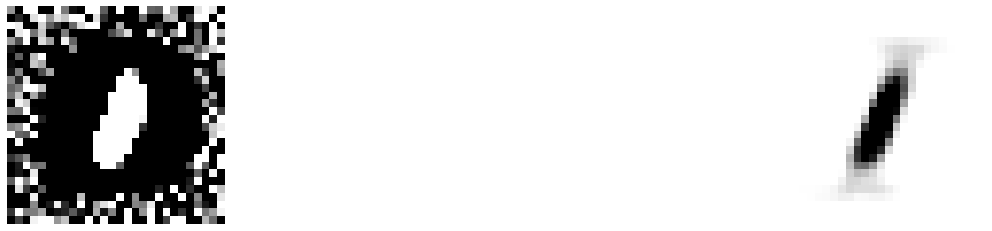

In [0]:
y = train(lr=0.1, epochs=20, digits=[0,1], nproxy=2)
plot_proxies(y, 2)

epoch: 0  L: -164.10984802246094
epoch: 1  L: -240.36166381835938
epoch: 2  L: -259.92352294921875
epoch: 3  L: -265.3570861816406
epoch: 4  L: -267.21307373046875
epoch: 5  L: -267.9267272949219
epoch: 6  L: -268.19818115234375
epoch: 7  L: -268.2777099609375
epoch: 8  L: -268.2695617675781
epoch: 9  L: -268.2204895019531
epoch: 10  L: -268.1534423828125
epoch: 11  L: -268.07940673828125
epoch: 12  L: -268.00396728515625
epoch: 13  L: -267.92974853515625
epoch: 14  L: -267.8581237792969
epoch: 15  L: -267.78961181640625
epoch: 16  L: -267.72430419921875
epoch: 17  L: -267.66229248046875
epoch: 18  L: -267.603271484375
epoch: 19  L: -267.5471496582031


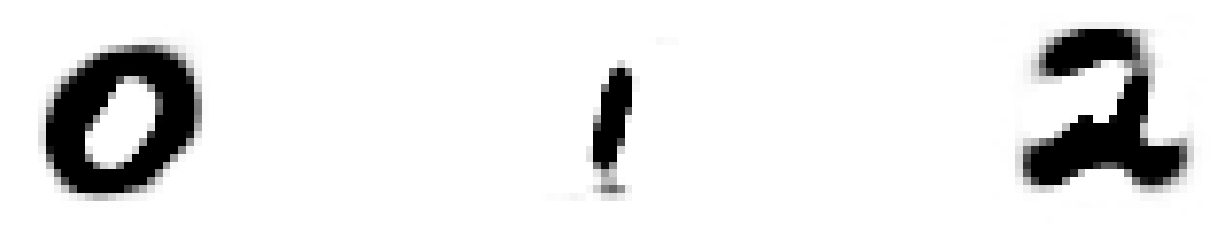

In [0]:
y = train(lr=0.1, epochs=20, digits=[0,1,2], nproxy=3)
plot_proxies(y, 3)

epoch: 0  L: -19.526092529296875
epoch: 1  L: -135.76736450195312
epoch: 2  L: -192.81512451171875
epoch: 3  L: -219.691162109375
epoch: 4  L: -232.57989501953125
epoch: 5  L: -239.02285766601562
epoch: 6  L: -242.38369750976562
epoch: 7  L: -244.20140075683594
epoch: 8  L: -245.2127685546875
epoch: 9  L: -245.78634643554688
epoch: 10  L: -246.1149139404297
epoch: 11  L: -246.3023681640625
epoch: 12  L: -246.40679931640625
epoch: 13  L: -246.46163940429688
epoch: 14  L: -246.48614501953125
epoch: 15  L: -246.49195861816406
epoch: 16  L: -246.48629760742188
epoch: 17  L: -246.47352600097656
epoch: 18  L: -246.45632934570312
epoch: 19  L: -246.43653869628906


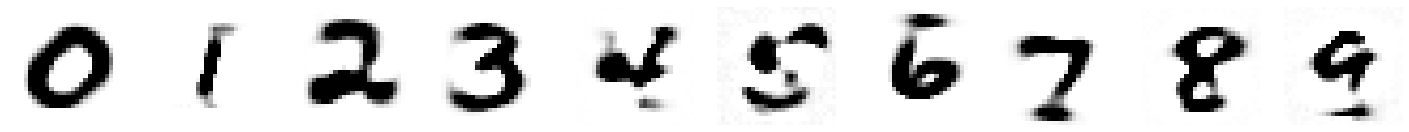

In [0]:
y = train(lr=0.1, epochs=20, digits=[0,1,2,3,4,5,6,7,8,9], nproxy=10)
plot_proxies(y, 10)

epoch: 0  L: -5574.21923828125
epoch: 1  L: -10592.7197265625
epoch: 2  L: -15621.6474609375
epoch: 3  L: -20653.556640625
epoch: 4  L: -25686.734375
epoch: 5  L: -30720.568359375
epoch: 6  L: -35754.78125
epoch: 7  L: -40789.23046875
epoch: 8  L: -45823.84765625
epoch: 9  L: -50858.57421875
epoch: 10  L: -55893.38671875
epoch: 11  L: -60928.28125
epoch: 12  L: -65963.2109375
epoch: 13  L: -70998.15625
epoch: 14  L: -76033.15625
epoch: 15  L: -81068.1875
epoch: 16  L: -86103.21875
epoch: 17  L: -91138.2734375
epoch: 18  L: -96173.3515625
epoch: 19  L: -101208.453125


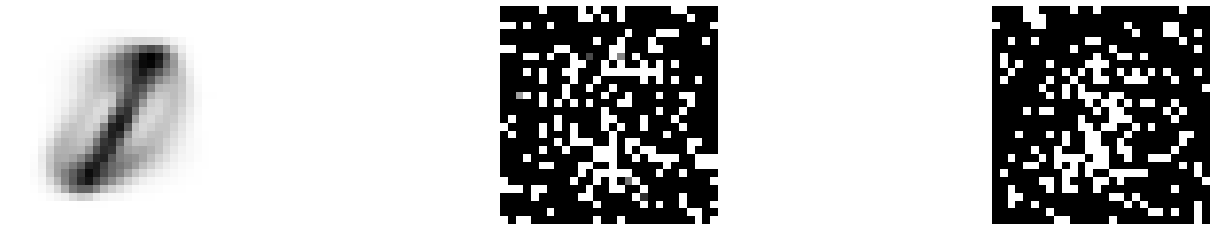

In [9]:
y = train(lr=0.1, epochs=20, digits=[0,1,2], nproxy=3, mode='unsupervised')
plot_proxies(y, 3)